In [43]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Activation, Conv2D, MaxPooling2D, Flatten, Dropout, Concatenate
from tensorflow.keras.datasets import fashion_mnist, mnist
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.backend import clear_session
from tensorflow.keras.utils import plot_model
from sklearn.utils import resample

In [2]:
(X_train_org, y_train_org), (X_test_org, y_test_org) = fashion_mnist.load_data()

X_train_org = X_train_org.reshape(-1, 28, 28, 1)
X_test_org = X_test_org.reshape(-1, 28, 28, 1)

X_train_org = X_train_org.astype('float32')
X_test_org = X_test_org.astype('float32')
X_train_org /= 255
X_test_org /= 255

X_train_org, y_train_org = resample(X_train_org, y_train_org, random_state=0)
X_test_org, y_test_org = resample(X_test_org, y_test_org, random_state=0)

In [3]:
def get_train_test_data(train_samples, test_samples):
    X_train = X_train_org[:train_samples]
    y_train = y_train_org[:train_samples]
    X_test = X_test_org[:test_samples]
    y_test = y_test_org[:test_samples]
    return X_train, y_train, X_test, y_test

In [53]:
def train_model(model, train_samples, test_samples, epochs=10, optimizer='adam', n=1):   
    X_train, y_train, X_test, y_test = get_train_test_data(train_samples, test_samples)  
    
    if n > 1:
        X_train = [X_train] * n
        X_test = [X_test] * n
    
    clear_session()
    np.random.seed(0x859)
    tf.random.set_seed(0x859)
      
    model.compile(optimizer=optimizer,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    
    history = model.fit(X_train, y_train, epochs=epochs, validation_data=(X_test, y_test), verbose=True)
    
    val_accuracy = history.history['val_accuracy'][-1]
    val_loss = history.history['val_loss'][-1]
    return val_accuracy, val_loss

In [120]:
from random import randint

layers_2_l = lambda name: [
    Input((28, 28, 1), name=f'Input_{name}'),
    Conv2D(32, (3,3), padding='same', activation='relu', name=f'Conv2D_1_{name}'),
    MaxPooling2D((2, 2), name=f'MaxPooling2D_1_{name}'),
    Conv2D(16, (3,3), padding='same', activation='relu', name=f'Conv2D_2_{name}'),
    MaxPooling2D((2, 2), name=f'MaxPooling2D_2_{name}'),
    Flatten(name=f'Flatten_{name}'),
    Dense(64, activation='relu', name=f'Dense_{name}'),
    Dense(10, activation='softmax')
]

In [117]:
def make_model(layers_factory, name):
    model = Sequential(layers_factory(name))
    return model

In [84]:
def freeze_model(model):
    model.trainable = False
    for layer in model.layers:
        layer.trainable = False

In [110]:
def rename_layers(model, suffix):  
    model.input.name = model.input.name + '_' + suffix
    for layer in model.layers:
        layer._name = layer.name + '_' + suffix

In [102]:
def make_ensemble_model(models):        
    model_ensemble = Concatenate()([model.layers[-2].output for model in models])
    model_ensemble = Dense(10, activation='softmax')(model_ensemble)  # or 'sigmoid'
    model_ensemble = Model(inputs=[model.input for model in models], outputs=model_ensemble)    
    return model_ensemble

In [135]:
sgd = SGD(learning_rate=0.01, momentum=0.9, nesterov=True, name='SGD')

train_samples = 4000
test_samples = 1000

def gen_4():
    for epochs in range(1, 13):
        model_sgd = make_model(layers_2_l, 'sgd')
        val_accuracy, val_loss = train_model(model_sgd, train_samples, test_samples, epochs, optimizer=sgd)
        yield 'sgd', epochs, val_accuracy, val_loss
        freeze_model(model_sgd)

        model_adam = make_model(layers_2_l, 'adam')
        val_accuracy, val_loss = train_model(model_adam, train_samples, test_samples, epochs, optimizer='adam')    
        yield 'adam', epochs, val_accuracy, val_loss
        freeze_model(model_adam)

        model_ensemble = make_ensemble_model([model_sgd, model_adam])
        accuracy, loss = train_model(model_ensemble, train_samples, test_samples, epochs, n=2, optimizer='adam')
        yield 'sgd+adam', epochs, accuracy, loss
        
results_4 = pd.DataFrame(gen_4(), columns=['model', 'epochs', 'val_accuracy', 'val_loss'])
results_4

125/125 [==============================] - 1s 9ms/step - loss: 1.9791 - accuracy: 0.4047 - val_loss: 1.0068 - val_accuracy: 0.6320
Epoch 1/2
125/125 [==============================] - 2s 15ms/step - loss: 1.1675 - accuracy: 0.5683 - val_loss: 0.7437 - val_accuracy: 0.7050
Epoch 2/2
125/125 [==============================] - 2s 15ms/step - loss: 0.7150 - accuracy: 0.7347 - val_loss: 0.6215 - val_accuracy: 0.7840
Epoch 1/2
125/125 [==============================] - 2s 18ms/step - loss: 1.0582 - accuracy: 0.6095 - val_loss: 0.7249 - val_accuracy: 0.7520
Epoch 2/2
125/125 [==============================] - 2s 18ms/step - loss: 0.6385 - accuracy: 0.7685 - val_loss: 0.5636 - val_accuracy: 0.8080
Epoch 1/2
125/125 [==============================] - 1s 9ms/step - loss: 1.7306 - accuracy: 0.4683 - val_loss: 0.8807 - val_accuracy: 0.7050
Epoch 2/2
125/125 [==============================] - 1s 7ms/step - loss: 0.7593 - accuracy: 0.7185 - val_loss: 0.6910 - val_accuracy: 0.7530
Epoch 1/3
125/125 [

125/125 [==============================] - 1s 8ms/step - loss: 0.5803 - accuracy: 0.8117 - val_loss: 0.5388 - val_accuracy: 0.8310
Epoch 3/6
125/125 [==============================] - 1s 7ms/step - loss: 0.4667 - accuracy: 0.8420 - val_loss: 0.4929 - val_accuracy: 0.8380
Epoch 4/6
125/125 [==============================] - 1s 7ms/step - loss: 0.4194 - accuracy: 0.8565 - val_loss: 0.4639 - val_accuracy: 0.8450
Epoch 5/6
125/125 [==============================] - 1s 7ms/step - loss: 0.3905 - accuracy: 0.8627 - val_loss: 0.4442 - val_accuracy: 0.8460
Epoch 6/6
125/125 [==============================] - 1s 7ms/step - loss: 0.3746 - accuracy: 0.8650 - val_loss: 0.4410 - val_accuracy: 0.8470
Epoch 1/7
125/125 [==============================] - 2s 14ms/step - loss: 1.1675 - accuracy: 0.5683 - val_loss: 0.7437 - val_accuracy: 0.7050
Epoch 2/7
125/125 [==============================] - 2s 14ms/step - loss: 0.7150 - accuracy: 0.7347 - val_loss: 0.6215 - val_accuracy: 0.7840
Epoch 3/7
125/125 [==

Epoch 9/9
125/125 [==============================] - 2s 14ms/step - loss: 0.3624 - accuracy: 0.8612 - val_loss: 0.4627 - val_accuracy: 0.8270
Epoch 1/9
125/125 [==============================] - 2s 16ms/step - loss: 1.0582 - accuracy: 0.6095 - val_loss: 0.7249 - val_accuracy: 0.7520
Epoch 2/9
125/125 [==============================] - 2s 16ms/step - loss: 0.6385 - accuracy: 0.7685 - val_loss: 0.5636 - val_accuracy: 0.8080
Epoch 3/9
125/125 [==============================] - 2s 15ms/step - loss: 0.5517 - accuracy: 0.7933 - val_loss: 0.5350 - val_accuracy: 0.7920
Epoch 4/9
125/125 [==============================] - 2s 16ms/step - loss: 0.4709 - accuracy: 0.8313 - val_loss: 0.4799 - val_accuracy: 0.8310
Epoch 5/9
125/125 [==============================] - 2s 16ms/step - loss: 0.4257 - accuracy: 0.8390 - val_loss: 0.4683 - val_accuracy: 0.8290
Epoch 6/9
125/125 [==============================] - 2s 17ms/step - loss: 0.3929 - accuracy: 0.8558 - val_loss: 0.4437 - val_accuracy: 0.8420
Epoch 

125/125 [==============================] - 2s 15ms/step - loss: 0.3624 - accuracy: 0.8612 - val_loss: 0.4627 - val_accuracy: 0.8270
Epoch 10/11
125/125 [==============================] - 2s 14ms/step - loss: 0.3367 - accuracy: 0.8773 - val_loss: 0.4856 - val_accuracy: 0.8250
Epoch 11/11
125/125 [==============================] - 2s 14ms/step - loss: 0.3325 - accuracy: 0.8680 - val_loss: 0.4409 - val_accuracy: 0.8400
Epoch 1/11
125/125 [==============================] - 2s 15ms/step - loss: 1.0582 - accuracy: 0.6095 - val_loss: 0.7249 - val_accuracy: 0.7520
Epoch 2/11
125/125 [==============================] - 2s 15ms/step - loss: 0.6385 - accuracy: 0.7685 - val_loss: 0.5636 - val_accuracy: 0.8080
Epoch 3/11
125/125 [==============================] - 2s 15ms/step - loss: 0.5517 - accuracy: 0.7933 - val_loss: 0.5350 - val_accuracy: 0.7920
Epoch 4/11
125/125 [==============================] - 2s 14ms/step - loss: 0.4709 - accuracy: 0.8313 - val_loss: 0.4799 - val_accuracy: 0.8310
Epoch 5/

125/125 [==============================] - 1s 8ms/step - loss: 0.2340 - accuracy: 0.9140 - val_loss: 0.3913 - val_accuracy: 0.8660
Epoch 10/12
125/125 [==============================] - 1s 8ms/step - loss: 0.2266 - accuracy: 0.9183 - val_loss: 0.3934 - val_accuracy: 0.8610
Epoch 11/12
125/125 [==============================] - 1s 10ms/step - loss: 0.2212 - accuracy: 0.9183 - val_loss: 0.3922 - val_accuracy: 0.8660
Epoch 12/12
125/125 [==============================] - 1s 9ms/step - loss: 0.2159 - accuracy: 0.9208 - val_loss: 0.3962 - val_accuracy: 0.8580


,model,epochs,val_accuracy,val_loss
0,sgd,1,0.705,0.743747
1,adam,1,0.752,0.724902
2,sgd+adam,1,0.632,1.006750
3,sgd,2,0.784,0.621467
4,adam,2,0.808,0.563583
5,sgd+adam,2,0.753,0.690960
6,sgd,3,0.796,0.544457
7,adam,3,0.792,0.534985
8,sgd+adam,3,0.794,0.585144
9,sgd,4,0.808,0.519859


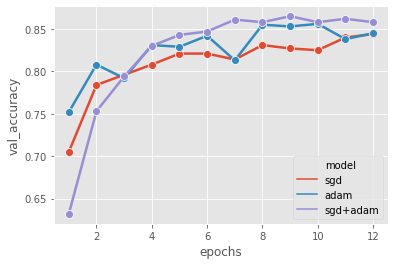

In [136]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

sns.lineplot(x='epochs', y='val_accuracy', hue='model', data=results_4, linewidth=2.5, marker='o', markersize=8)